# Imports

Declare all libraries

In [39]:
import os
import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score

# Data

Import data

In [2]:
dir = os.getcwd()
dataSetPaths = {
	"test": os.path.join(dir, "resources/test.csv"),
	"train": os.path.join(dir, "resources/train.csv")
}

dataSets = {}

# Defining Reusable Functions

Define functions that could act as reusable codes.

In [27]:
def createSubmissionFile(yPred, filename):
	sf = pd.read_csv(os.path.join(dir, 'resources/sample_submission.csv'))
	id = sf.pop('id')

	submission = pd.DataFrame({
		'id': id,
		'loan_status': yPred
	})

	submission.to_csv(
		os.path.join(dir, "dist", filename + ".csv"),
		index = False
	)

def splitData(dataSet, scaleData = False, testSize = 0.2):
	x = dataSet.drop('loan_status', axis = 1)
	y = dataSet['loan_status']

	train = {}
	test = {} 

	train['x'], test['x'], train['y'], test['y'] = train_test_split(x, y, test_size = testSize)

	if scaleData:
		scaler = StandardScaler()
		train['x'] = scaler.fit_transform(train['x'])
		test['x'] = scaler.transform(test['x'])

	return train, test

def selectFeatures(xTrain, yTrain, columns, criterion = "gini", printReport = True):
	featureSelector = trainRandomForest(xTrain, yTrain, criterion)

	yPred = featureSelector.predict(xTrain)

	if printReport:
		print(classification_report(yTrain, yPred))

	return pd.DataFrame(
		{'rfc': featureSelector.feature_importances_},
		index = columns
	)

def trainDecisionTree(xTrain, yTrain, criterion = "gini"):
	clf = DecisionTreeClassifier(criterion = criterion)
	clf.fit(xTrain, yTrain)

	print(f"DT Score: {cross_val_score(clf, xTrain, yTrain, cv = 5)}")

	return clf

def trainRandomForest(xTrain, yTrain, criterion = "gini"):
	clf = RandomForestClassifier(criterion = criterion)
	clf.fit(xTrain, yTrain)

	print(f"RFE Score: {cross_val_score(clf, xTrain, yTrain, cv = 5)}")

	return clf

In [4]:
for key in dataSetPaths:
	print()
	dataSets[key] = pd.read_csv(dataSetPaths[key])
	print(f"\"{key}\" data set shape: {dataSets[key].shape}")
	print(f"Info:")
	dataSets[key].info()


"test" data set shape: (39098, 12)
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39098 non-null  int64  
 1   person_age                  39098 non-null  int64  
 2   person_income               39098 non-null  int64  
 3   person_home_ownership       39098 non-null  object 
 4   person_emp_length           39098 non-null  float64
 5   loan_intent                 39098 non-null  object 
 6   loan_grade                  39098 non-null  object 
 7   loan_amnt                   39098 non-null  int64  
 8   loan_int_rate               39098 non-null  float64
 9   loan_percent_income         39098 non-null  float64
 10  cb_person_default_on_file   39098 non-null  object 
 11  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usag

# Pre-Processing

Feature engineering and processing of data.

In [5]:
dataSets["train"].head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [6]:
dataSets["train"]["loan_status"].value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

In [7]:
for key in dataSets:
	print(f"\nNo. of null in \"{key}\":\n{dataSets[key].isnull().sum()}")


No. of null in "test":
id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

No. of null in "train":
id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64


## Morphing Features

Morph some features so that they are quantifiable

In [8]:
dataSets["train"]["loan_grade"].unique()

array(['B', 'C', 'A', 'D', 'E', 'F', 'G'], dtype=object)

In [9]:

for key in dataSets:
    # Person Home Ownership
    ## - MORTGAGE => 0
    ## - RENT => 1
    ## - OWN => 2
    ## - OTHER => 3
	dataSets[key]["person_home_ownership"] = dataSets[key]["person_home_ownership"].map({
		"MORTGAGE": 0,
		"RENT": 1,
		"OWN": 2,
		"OTHER": 3
	})

	# Loan Intent
	## - EDUCATION => 0
	## - PERSONAL => 1
	## - VENTURE => 2
	## - DEBTCONSOLIDATION => 3
	## - HOMEIMPROVEMENT => 4
	## - MEDICAL => 5
	dataSets[key]["loan_intent"] = dataSets[key]["loan_intent"].map({
		"EDUCATION": 0,
		"PERSONAL": 1,
		"VENTURE": 2,
		"DEBTCONSOLIDATION": 3,
		"HOMEIMPROVEMENT": 4,
		"MEDICAL": 5
	})

	# Loan Grade
	## - A => 0
	## - B => 1
	## - C => 2
	## - D => 3
	## - E => 4
	## - F => 5
	## - G => 6
	dataSets[key]["loan_grade"] = dataSets[key]["loan_grade"].map({
		"A": 0,
		"B": 1,
		"C": 2,
		"D": 3,
		"E": 4,
		"F": 5,
		"G": 6
	})

	# CB Person Default on file
	dataSets[key]["cb_person_default_on_file"] = dataSets[key]["cb_person_default_on_file"].map({
		"Y": 1,
		"N": 0
	})

	# Remove ID
	dataSets[key].drop(['id'], axis = 1, inplace = True)
	print(f"Cols ({key}): {dataSets[key].columns}")

Cols (test): Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length'],
      dtype='object')
Cols (train): Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')


# Model Training

Begin the training of the models

In [10]:
print(len(dataSets["train"].columns))

12


## Decision Tree Classifier Model

In [16]:
ogCols = dataSets["train"].columns
ogIndex = dataSets["train"].drop("loan_status", axis = 1).columns
dtTrainOg, dtTestOg = splitData(dataSets["train"], scaleData = True)
dtTrain = dtTrainOg.copy()
dtTest = dtTestOg.copy()

## Experimentation

In [17]:
# # Feature Selection
# featureFrame = selectFeatures(dtTrain['x'], dtTrain['y'], ogIndex, printReport = False)
# featureFrame.sort_values(by = 'rfc', ascending = True, inplace = True)
# index = np.arange(len(featureFrame))
# fig, ax = plt.subplots(figsize = (10, 10))
# selectedFeatures = ax.barh(index, featureFrame['rfc'], 0.5, color = 'blue', label = 'Feature Importance')
# ax.set(yticks = index, yticklabels = featureFrame.index)

# ax.legend()
# plt.show()

# # WITHOUT REMOVED FEATURES
# decisionTreeModel = trainDecisionTree(dtTrain['x'], dtTrain['y'])
# yPred = decisionTreeModel.predict(dtTest['x'])

# print(f"Decision Tree Model Accuracy (Before Feature Selection): {decisionTreeModel.score(dtTest['x'], dtTest['y'])}")

# # WITH REMOVED FEATURES
# toRemove = featureFrame.index[:int(len(featureFrame) / 2)]
# dtTrain, dtTest = splitData(dataSets["train"].drop(toRemove, axis = 1), scaleData = True)

# decisionTreeModel = trainDecisionTree(dtTrain['x'], dtTrain['y'])
# yPred = decisionTreeModel.predict(dtTest['x'])

# print(f"Decision Tree Model Accuracy (After Feature Selection): {decisionTreeModel.score(dtTest['x'], dtTest['y'])}")

## Actual

This is the actual DT codes. Disregard above. It's for experimentation.

DT Score: [0.9105925  0.91164873 0.91271448 0.90855803 0.90994351]
Decision Tree Model Accuracy: 0.9120982180919089


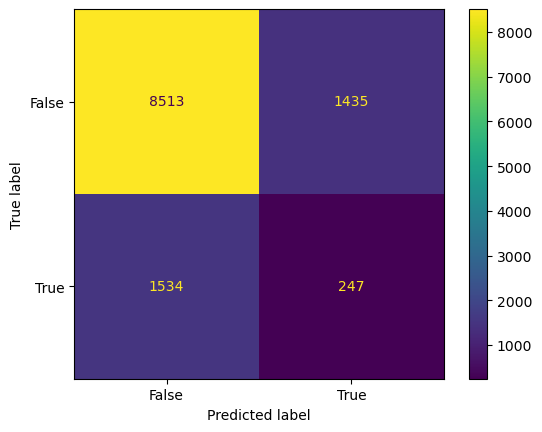

In [41]:
dfTrain, dfTest = splitData(dataSets["train"].copy(), True)
decisionTreeModel = trainDecisionTree(dtTrain['x'], dtTrain['y'])
yDTPred = decisionTreeModel.predict(dtTest['x'])

print(f"Decision Tree Model Accuracy: {decisionTreeModel.score(dtTest['x'], dtTest['y'])}")
cm = confusion_matrix(yDTPred, dfTest['y'])
cmDisplay = ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels = ["False", "True"]
)

cmDisplay.plot()
plt.show()

## Random Forest Classifier Model

RFE Score: [0.95311168 0.95065544 0.94873708 0.94585953 0.95140147]
Decision Tree Model Accuracy: 0.9120982180919089


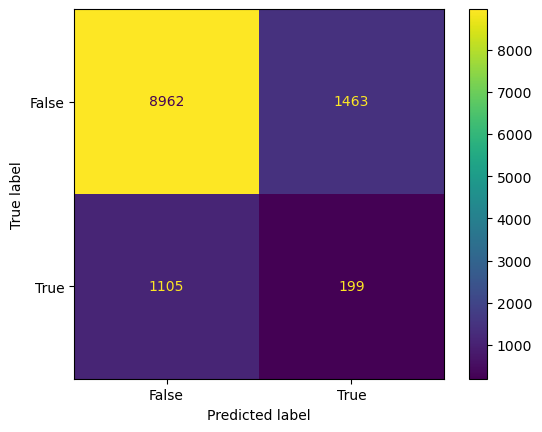

In [42]:
dfTrain, dfTest = splitData(dataSets["train"].copy(), True)
rfeModel = trainRandomForest(dtTrain['x'], dtTrain['y'])
yRFEPred = rfeModel.predict(dtTest['x'])

print(f"Random Forest Model Accuracy: {rfeModel.score(dtTest['x'], dtTest['y'])}")
cm = confusion_matrix(yRFEPred, dfTest['y'])
cmDisplay = ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels = ["False", "True"]
)

cmDisplay.plot()
plt.show()

# Submission File

In [43]:
yDTPred = decisionTreeModel.predict(dataSets["test"])
yRFEPred = rfeModel.predict(dataSets["test"])

c:\Users\Virus5600\miniconda3\envs\com222\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Virus5600\miniconda3\envs\com222\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [44]:
createSubmissionFile(yDTPred, "DecisionTree")
createSubmissionFile(yRFEPred, "RFE")